In [1]:
from pathlib import Path
import json
from collections import Counter
from enum import Enum
from typing import List, Union

class VulnCategory(str, Enum):
    WEB_APP = "WEB_APP"
    API = "API"

class SeverityLevel(str, Enum):
    HIGH = "HIGH"
    MEDIUM = "MEDIUM"
    LOW = "LOW"

def map_severity_to_level(severity: Union[List[float], None]) -> str:
    """Map severity scores to standardized levels
    
    Args:
        severity: List of severity scores or None
    Returns:
        Severity level string
    """
    if not severity:  # Handle None or empty list
        return SeverityLevel.LOW.value
        
    # Filter out None values and convert to float
    valid_scores = [float(score) for score in severity if score is not None]
    
    if not valid_scores:  # If no valid scores after filtering
        return SeverityLevel.LOW.value
    
    # Use the highest severity score
    max_severity = max(valid_scores)
    
    if max_severity >= 7.0:
        return SeverityLevel.HIGH.value
    elif max_severity >= 4.0:
        return SeverityLevel.MEDIUM.value
    else:
        return SeverityLevel.LOW.value

def analyze_vulnerability_categories():
    reports_dir = Path("reports")
    # Create nested counters for each category and severity
    category_severity_counts = {
        VulnCategory.WEB_APP.value: Counter(),
        VulnCategory.API.value: Counter()
    }
    category_totals = Counter()

    # Process all JSON files in the reports directory
    for report_file in reports_dir.glob("*.json"):
        with open(report_file, "r") as f:
            try:
                report = json.load(f)
                category = report.get("vuln_category")
                
                # Only process WEB_APP and API vulnerabilities
                if category not in [VulnCategory.WEB_APP.value, VulnCategory.API.value]:
                    continue
                
                severity = map_severity_to_level(report.get("severity"))
                category_severity_counts[category][severity] += 1
                category_totals[category] += 1
                
            except json.JSONDecodeError:
                print(f"Error reading {report_file}")
                continue

    # Print the results
    print("\nVulnerability Analysis by Category and Severity")
    print("=" * 45)
    
    for category in [VulnCategory.WEB_APP.value, VulnCategory.API.value]:
        total = category_totals[category]
        print(f"\n{category} Vulnerabilities (Total: {total})")
        print("-" * 35)
        
        for severity in SeverityLevel:
            count = category_severity_counts[category][severity.value]
            percentage = (count / total * 100) if total > 0 else 0
            print(f"{severity.value:6}: {count:3} ({percentage:.1f}%)")

# if __name__ == "__main__":
#     analyze_vulnerability_categories()


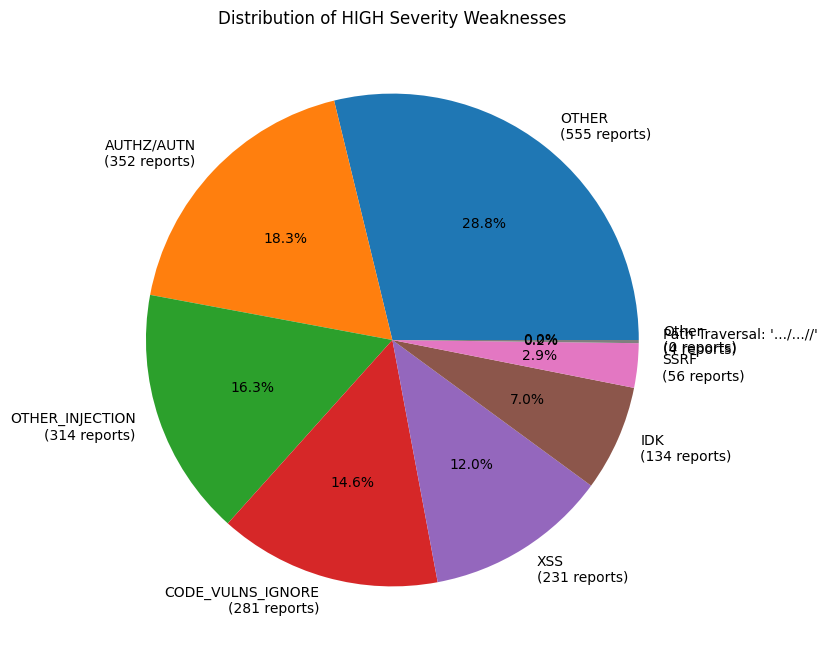

In [3]:
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt

START_YEAR = 2012
END_YEAR = 2026

def epoch_to_year(epoch_time):
    """Convert Unix epoch timestamp to year
    
    Args:
        epoch_time (int): Unix epoch timestamp
        
    Returns:
        int: Year extracted from timestamp
    """
    return datetime.fromtimestamp(epoch_time).year

def convert_weakness(weakness):
    ISSUES_MAPPING = {
        "XSS": [
            "Cross-site Scripting (XSS) - Stored",
            "Cross-site Scripting (XSS) - DOM", 
            "Cross-site Scripting (XSS) - Reflected",
            "Cross-site Scripting (XSS) - Generic",
            "Reflected XSS"
        ],
        "AUTHZ/AUTN": [
            "Improper Access Control - Generic",
            "Insecure Direct Object Reference (IDOR)",
            "Improper Authentication - Generic", 
            "Authentication Bypass Using an Alternate Path or Channel",
            "Improper Authorization",
            "Authentication Bypass",
            "Missing Critical Step in Authentication",
            "Incorrect Authorization",
            "Improper Privilege Management",
            "Incorrect Privilege Assignment",
            "Privilege Escalation",
        ],
        "OTHER_INJECTION" : [
            "SQL Injection",
            "Blind SQL Injection",
            "Command Injection - Generic",
            "OS Command Injection",
            "Code Injection",
            "XML External Entities (XXE)",
            "Resource Injection",
            "XML Injection",
            "LDAP Injection",
            "Use of Externally-Controlled Format String",
            "Remote File Inclusion",
            "PHP Local File Inclusion"
        ],
        "SSRF": [
            "Server-Side Request Forgery (SSRF)"
        ],
        "OTHER" : [
            "Information Disclosure",
            "Path Traversal",
            "Business Logic Errors",
            "Cross-Site Request Forgery (CSRF)",
            "Violation of Secure Design Principles",
            "HTTP Request Smuggling",
            "Insecure Storage of Sensitive Information",
            "Cryptographic Issues - Generic",
            "Improper Restriction of Authentication Attempts",
            "Improper Input Validation",
            "Cleartext Storage of Sensitive Information",
            "Information Exposure Through Directory Listing",
            "Misconfiguration",
            "Privacy Violation",
            "Insufficiently Protected Credentials",
            "Open Redirect",
            "UI Redressing (Clickjacking)",
            "Improper Certificate Validation",
            "Phishing",
            "Path Traversal: '.../.../'",
            "Man-in-the-Middle",
            "Weak Password Recovery Mechanism for Forgotten Password",
            "Use of Hard-coded Credentials",
            "Missing Encryption of Sensitive Data",
            "Information Exposure Through Debug Information",
            "Unverified Password Change",
            "Session Fixation",
            "CRLF Injection",
            "HTTP Response Splitting",
            "Security Through Obscurity",
            "Reliance on Cookies without Validation and Integrity Checking in a Security Decision",
            "Unrestricted Upload of File with Dangerous Type",
            "Insufficient Session Expiration",
            "File and Directory Information Exposure",
            "Information Exposure Through an Error Message",
            "User Interface (UI) Misrepresentation of Critical Information",
            "Malware",
            "Password in Configuration File",
            "Storing Passwords in a Recoverable Format",
            "Leftover Debug Code (Backdoor)",
            "Use of a Broken or Risky Cryptographic Algorithm",
            "Externally Controlled Reference to a Resource in Another Sphere",
            "Weak Cryptography for Passwords",
            "Reusing a Nonce, Key Pair in Encryption",
            "Information Exposure Through Sent Data",
            "Improper Check or Handling of Exceptional Conditions",
            "Untrusted Search Path",
            "Use of Cryptographically Weak Pseudo-Random Number Generator (PRNG)",
            "Use of Cache Containing Sensitive Information",
            "Use of Default Credentials",
            "Cleartext Transmission of Sensitive Information",
            "Use of a Key Past its Expiration Date",
            "Plaintext Storage of a Password",
            "Forced Browsing",
            "Encoding Error",
            "Inclusion of Functionality from Untrusted Control Sphere",
            "File Manipulation",
            "Using Components with Known Vulnerabilities",
            "Key Exchange without Entity Authentication",
            "Missing Required Cryptographic Step",
            "Embedded Malicious Code",
            "XML Entity Expansion",
            "Use of Hard-coded Cryptographic Key",
            "Reliance on Untrusted Inputs in a Security Decision",
            "Exposed Dangerous Method or Function",
            "Improper Handling of URL Encoding (Hex Encoding)",
            "Download of Code Without Integrity Check",
            "Use of Hard-coded Password"
        ],
        "CODE_VULNS_IGNORE" : [
            "Memory Corruption - Generic",
            "Buffer Over-read",
            "Classic Buffer Overflow",
            "Heap Overflow",
            "Use After Free",
            "Out-of-bounds Read",
            "Stack Overflow",
            "NULL Pointer Dereference",
            "Buffer Underflow",
            "Integer Overflow",
            "Improper Null Termination",
            "Double Free",
            "Array Index Underflow",
            "Use of Inherently Dangerous Function",
            "Type Confusion",
            "Write-what-where Condition",
            "Incorrect Calculation of Buffer Size",
            "Off-by-one Error",
            "Uncontrolled Resource Consumption",
            "Deserialization of Untrusted Data",
            "Allocation of Resources Without Limits or Throttling",
            "Time-of-check Time-of-use (TOCTOU) Race Condition",
            "Modification of Assumed-Immutable Data (MAID)",
            "External Control of Critical State Data"
        ],
        "IDK" : [
            "None",
            "Other"
        ]

    }
    # Check if weakness matches any values in the mapping
    for key, values in ISSUES_MAPPING.items():
        if weakness in values:
            return key
            
    # Return original weakness if no match found
    return weakness

def analyze_top_weaknesses():
    """Analyze top 9 weaknesses across all years (HIGH severity only)"""
    reports_dir = Path("reports")
    
    # Initialize weakness counter
    weakness_counts = Counter()
    
    # Process all reports
    for report_file in reports_dir.glob("*.json"):
        with open(report_file, "r") as f:
            try:
                report = json.load(f)
                
                # Skip if not HIGH severity
                severity = map_severity_to_level(report.get("severity"))
                if severity != SeverityLevel.HIGH.value:
                    continue
                    
                weaknesses = report.get("weaknesses", [])
                if not weaknesses:
                    continue
                    
                # Count each weakness
                for weakness in weaknesses:
                    weakness = convert_weakness(weakness)
                    weakness_counts[weakness] += 1
                    
            except (json.JSONDecodeError, KeyError):
                continue
                
    # Get top 9 weaknesses
    top_9 = weakness_counts.most_common(9)
    
    # Calculate sum of other weaknesses
    top_9_names = [w[0] for w in top_9]
    other_sum = sum(count for weakness, count in weakness_counts.items() 
                   if weakness not in top_9_names)
    
    # Prepare data for pie chart
    labels = [f"{weakness}\n({count} reports)" for weakness, count in top_9]
    labels.append(f"Other\n({other_sum} reports)")
    
    sizes = [count for _, count in top_9]
    sizes.append(other_sum)
    
    # Create pie chart
    fig, ax = plt.subplots(figsize=(15, 8))
    ax.pie(sizes, labels=labels, autopct="%1.1f%%")
    ax.set_title("Distribution of HIGH Severity Weaknesses")
    
    plt.show()

# Run the analysis
analyze_top_weaknesses()


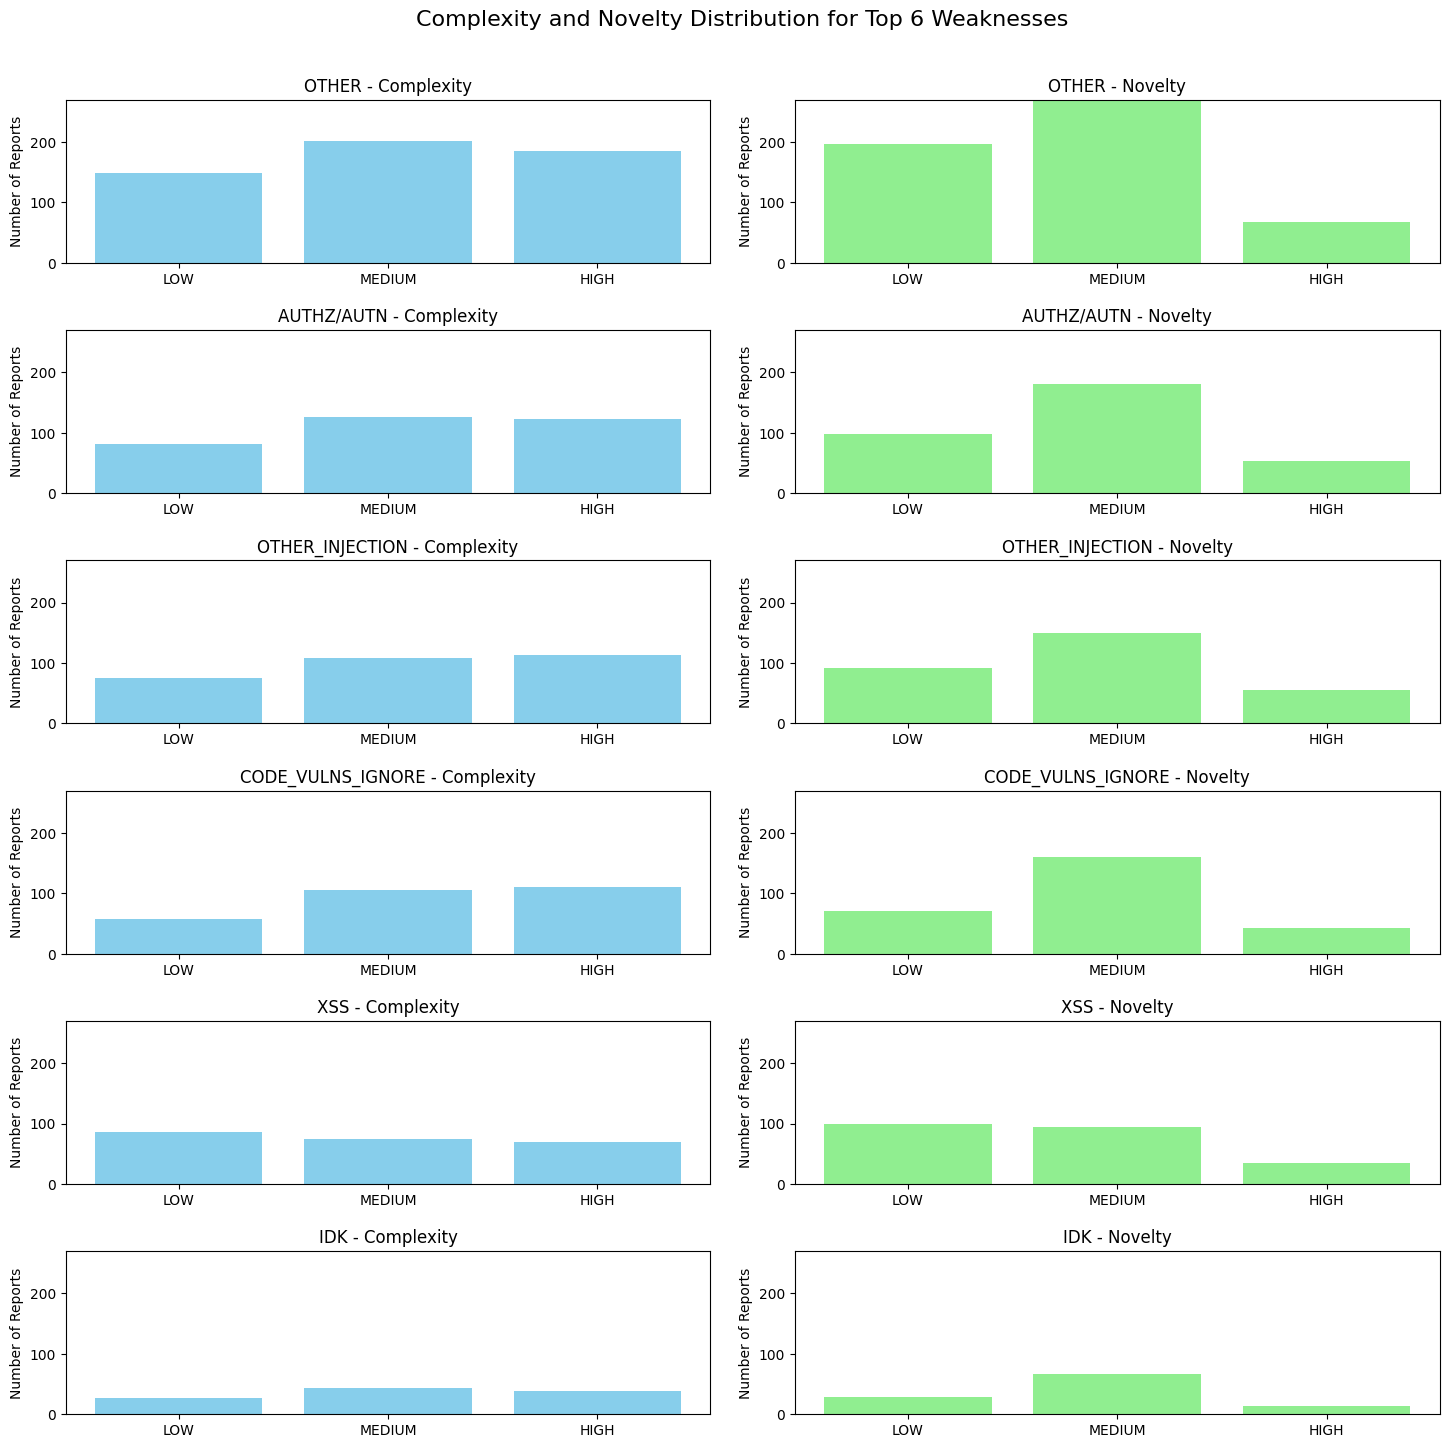

In [7]:
from pathlib import Path
import json
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from enum import Enum
from typing import Union, List

class SeverityLevel(Enum):
    HIGH = "HIGH"
    MEDIUM = "MEDIUM"
    LOW = "LOW"

def map_severity_to_level(severity: Union[List[float], None]) -> str:
    """Map severity scores to standardized levels
    
    Args:
        severity: List of severity scores or None
    Returns:
        Severity level string
    """
    if not severity:  # Handle None or empty list
        return SeverityLevel.LOW.value
        
    # Filter out None values and convert to float
    valid_scores = [float(score) for score in severity if score is not None]
    
    if not valid_scores:  # If no valid scores after filtering
        return SeverityLevel.LOW.value
    
    # Use the highest severity score
    max_severity = max(valid_scores)
    
    if max_severity >= 7.0:
        return SeverityLevel.HIGH.value
    elif max_severity >= 4.0:
        return SeverityLevel.MEDIUM.value
    else:
        return SeverityLevel.LOW.value

def analyze_weakness_complexity_novelty():
    """Analyze complexity and novelty for top 6 weaknesses"""
    reports_dir = Path("high_reports")
    
    # Initialize weakness counter
    weakness_counts = Counter()
    weakness_data = {}
    
    # Process all reports
    for report_file in reports_dir.glob("*.json"):
        with open(report_file, "r") as f:
            try:
                report = json.load(f)
                
                # Skip if not HIGH severity
                severity = map_severity_to_level(report.get("severity"))
                if severity != SeverityLevel.HIGH.value:
                    continue
                
                complexity = report.get("complexity")
                novelty = report.get("novelty")
                
                weaknesses = report.get("weaknesses", [])
                if not weaknesses:
                    continue
                
                # Count each weakness and collect complexity/novelty data
                for weakness in weaknesses:
                    weakness = convert_weakness(weakness)
                    weakness_counts[weakness] += 1
                    
                    if weakness not in weakness_data:
                        weakness_data[weakness] = {"complexity": [], "novelty": []}
                    
                    if complexity:
                        weakness_data[weakness]["complexity"].append(complexity)
                    if novelty:
                        weakness_data[weakness]["novelty"].append(novelty)
                    
            except (json.JSONDecodeError, KeyError):
                continue
    
    # Get top 6 weaknesses
    top_6 = [w for w, _ in weakness_counts.most_common(6)]
    
    # Create a figure with 6 rows and 2 columns
    fig, axes = plt.subplots(6, 2, figsize=(15, 15))
    fig.tight_layout(pad=3.0)
    
    # Define categories for complexity and novelty
    complexity_categories = ["LOW", "MEDIUM", "HIGH"]
    novelty_categories = ["LOW", "MEDIUM", "HIGH"]
    
    # Find the maximum count across all histograms to set a consistent y-axis
    max_count = 0
    for weakness in top_6:
        if weakness in weakness_data:
            complexity_data = weakness_data[weakness]["complexity"]
            novelty_data = weakness_data[weakness]["novelty"]
            
            complexity_counts = Counter(complexity_data)
            novelty_counts = Counter(novelty_data)
            
            max_count = max(max_count, 
                           max([complexity_counts.get(cat, 0) for cat in complexity_categories], default=0),
                           max([novelty_counts.get(cat, 0) for cat in novelty_categories], default=0))
    
    # Plot histograms for each weakness
    for i, weakness in enumerate(top_6):
        if weakness in weakness_data:
            # Complexity histogram
            complexity_data = weakness_data[weakness]["complexity"]
            complexity_counts = Counter(complexity_data)
            
            # Convert to arrays for plotting
            complexity_values = [complexity_counts.get(cat, 0) for cat in complexity_categories]
            
            axes[i, 0].bar(complexity_categories, complexity_values, color="skyblue")
            axes[i, 0].set_title(f"{weakness} - Complexity")
            axes[i, 0].set_ylabel("Number of Reports")
            axes[i, 0].set_ylim(0, max_count)  # Set consistent y-axis limit
            
            # Novelty histogram
            novelty_data = weakness_data[weakness]["novelty"]
            novelty_counts = Counter(novelty_data)
            
            # Convert to arrays for plotting
            novelty_values = [novelty_counts.get(cat, 0) for cat in novelty_categories]
            
            axes[i, 1].bar(novelty_categories, novelty_values, color="lightgreen")
            axes[i, 1].set_title(f"{weakness} - Novelty")
            axes[i, 1].set_ylabel("Number of Reports")
            axes[i, 1].set_ylim(0, max_count)  # Set consistent y-axis limit
    
    plt.suptitle("Complexity and Novelty Distribution for Top 6 Weaknesses", fontsize=16)
    plt.subplots_adjust(top=0.92)
    plt.show()

# Run the analysis
analyze_weakness_complexity_novelty()


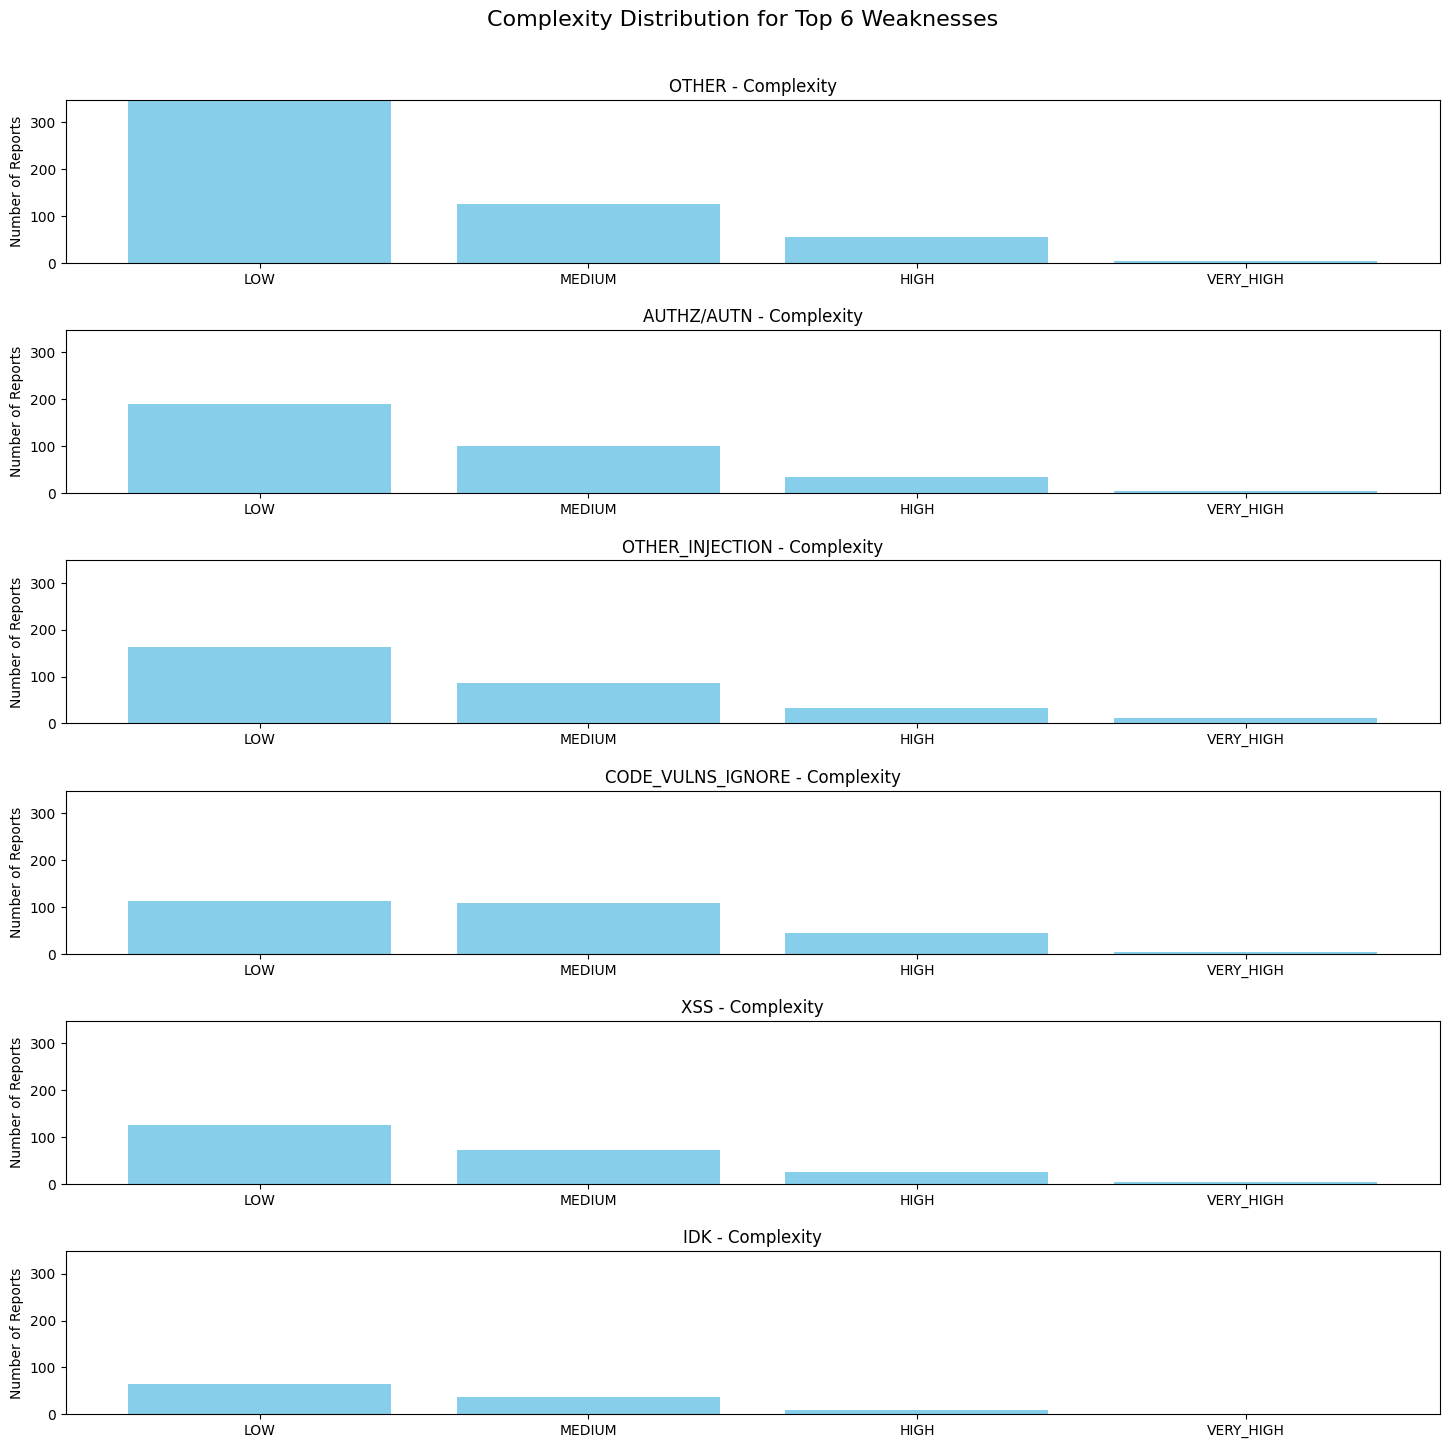

In [13]:
from pathlib import Path
import json
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from enum import Enum
from typing import Union, List

class SeverityLevel(Enum):
    HIGH = "HIGH"
    MEDIUM = "MEDIUM"
    LOW = "LOW"

def map_severity_to_level(severity: Union[List[float], None]) -> str:
    """Map severity scores to standardized levels
    
    Args:
        severity: List of severity scores or None
    Returns:
        Severity level string
    """
    if not severity:  # Handle None or empty list
        return SeverityLevel.LOW.value
        
    # Filter out None values and convert to float
    valid_scores = [float(score) for score in severity if score is not None]
    
    if not valid_scores:  # If no valid scores after filtering
        return SeverityLevel.LOW.value
    
    # Use the highest severity score
    max_severity = max(valid_scores)
    
    if max_severity >= 7.0:
        return SeverityLevel.HIGH.value
    elif max_severity >= 4.0:
        return SeverityLevel.MEDIUM.value
    else:
        return SeverityLevel.LOW.value

def analyze_weakness_complexity_novelty():
    """Analyze complexity and novelty for top 6 weaknesses"""
    reports_dir = Path("high_reports")
    
    # Initialize weakness counter
    weakness_counts = Counter()
    weakness_data = {}
    
    # Process all reports
    for report_file in reports_dir.glob("*.json"):
        with open(report_file, "r") as f:
            try:
                report = json.load(f)
                
                # Skip if not HIGH severity
                severity = map_severity_to_level(report.get("severity"))
                if severity != SeverityLevel.HIGH.value:
                    continue
                
                complexity = report.get("new_complexity")
                
                weaknesses = report.get("weaknesses", [])
                if not weaknesses:
                    continue
                
                # Count each weakness and collect complexity data
                for weakness in weaknesses:
                    weakness = convert_weakness(weakness)
                    weakness_counts[weakness] += 1
                    
                    if weakness not in weakness_data:
                        weakness_data[weakness] = {"complexity": []}
                    
                    if complexity:
                        weakness_data[weakness]["complexity"].append(complexity)
                    
            except (json.JSONDecodeError, KeyError):
                continue
    
    # Get top 6 weaknesses
    top_6 = [w for w, _ in weakness_counts.most_common(6)]
    
    # Create a figure with 6 rows and 1 column
    fig, axes = plt.subplots(6, 1, figsize=(15, 15))
    fig.tight_layout(pad=3.0)
    
    # Define categories for complexity
    complexity_categories = ["LOW", "MEDIUM", "HIGH", "VERY_HIGH"]
    
    # Find the maximum count across all histograms to set a consistent y-axis
    max_count = 0
    for weakness in top_6:
        if weakness in weakness_data:
            complexity_data = weakness_data[weakness]["complexity"]
            
            complexity_counts = Counter(complexity_data)
            
            max_count = max(max_count, 
                           max([complexity_counts.get(cat, 0) for cat in complexity_categories], default=0))
    
    # Plot histograms for each weakness
    for i, weakness in enumerate(top_6):
        if weakness in weakness_data:
            # Complexity histogram
            complexity_data = weakness_data[weakness]["complexity"]
            complexity_counts = Counter(complexity_data)
            
            # Convert to arrays for plotting
            complexity_values = [complexity_counts.get(cat, 0) for cat in complexity_categories]
            
            axes[i].bar(complexity_categories, complexity_values, color="skyblue")
            axes[i].set_title(f"{weakness} - Complexity")
            axes[i].set_ylabel("Number of Reports")
            axes[i].set_ylim(0, max_count)  # Set consistent y-axis limit
    
    plt.suptitle("Complexity Distribution for Top 6 Weaknesses", fontsize=16)
    plt.subplots_adjust(top=0.92)
    plt.show()

# Run the analysis
analyze_weakness_complexity_novelty()


Error processing high_reports\1092574.json: Expecting value: line 1 column 1 (char 0)
Error processing high_reports\1618100.json: Expecting value: line 1 column 1 (char 0)
Error processing high_reports\183239.json: Expecting value: line 1 column 1 (char 0)
Error processing high_reports\186194.json: Expecting value: line 1 column 1 (char 0)
Error processing high_reports\192321.json: Expecting value: line 1 column 1 (char 0)
Error processing high_reports\217745.json: Expecting value: line 1 column 1 (char 0)
Error processing high_reports\312118.json: Expecting value: line 1 column 1 (char 0)
Error processing high_reports\744692.json: Expecting value: line 1 column 1 (char 0)
TOTAL BOUNTY FOR  LOW : 507580
TOTAL BOUNTY FOR  MEDIUM : 706449
TOTAL BOUNTY FOR  HIGH : 708960


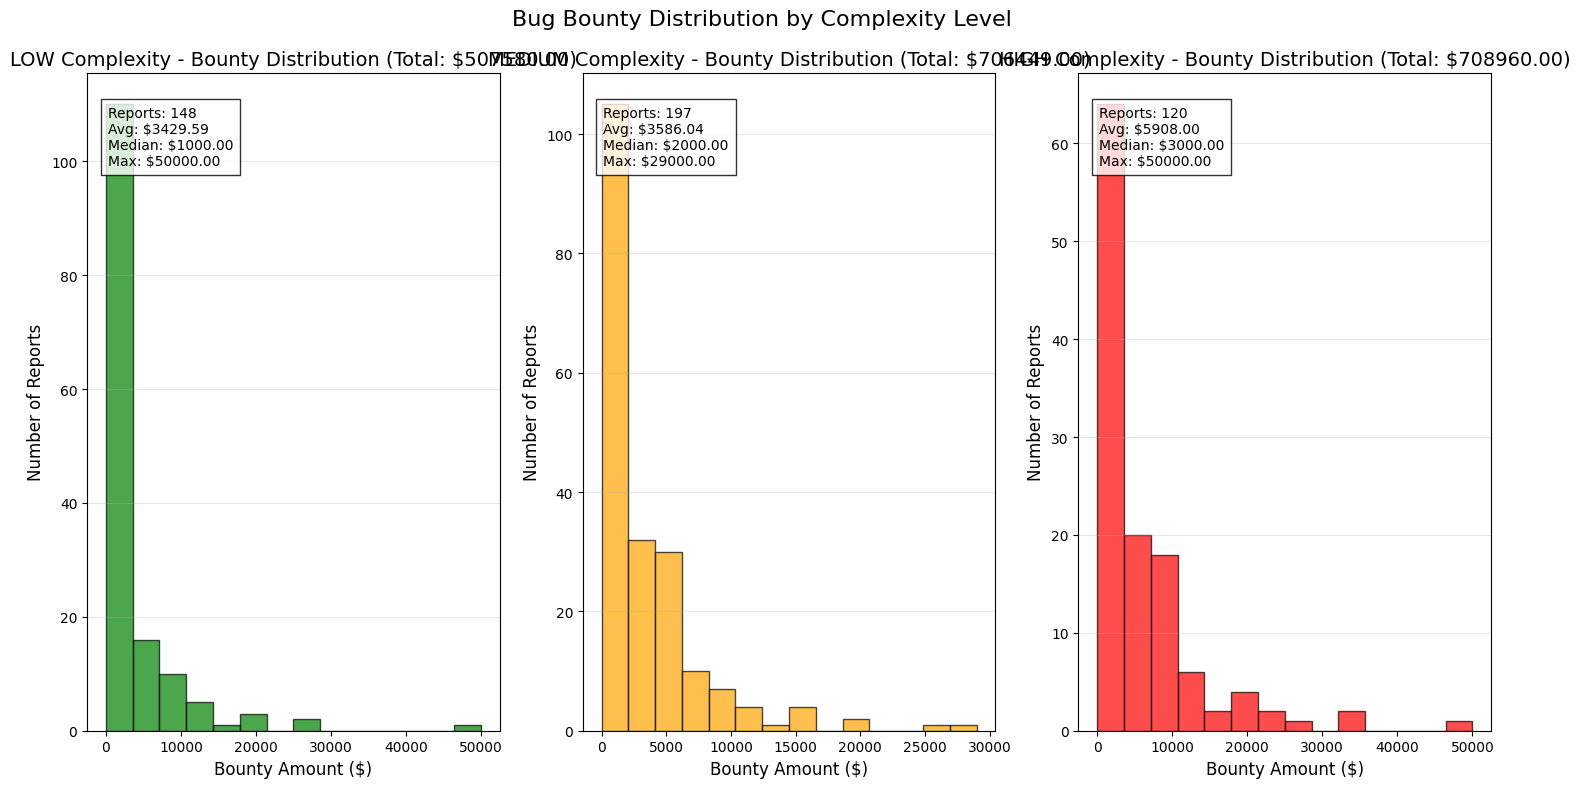

In [14]:
import os
import json
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

def analyze_bounty_distribution():
    """
    Analyze and visualize the distribution of bug bounty amounts from reports
    in the scrapers/high_reports directory, separated by complexity level.
    """
    # Path to the reports directory
    reports_dir = Path("high_reports")
    
    # Dictionaries to store bounty amounts by complexity
    bounties_by_complexity = {
        "LOW": [],
        "MEDIUM": [],
        "HIGH": []  # This will include both HIGH and VERY_HIGH
    }
    
    # Iterate through all JSON files in the directory
    for file_path in reports_dir.glob("*.json"):
        try:
            with open(file_path, "r") as f:
                report = json.load(f)
                
                # Check if bounty exists and is not None
                if "bounty" in report and report["bounty"] is not None:
                    # Use new_complexity field instead of complexity
                    complexity = report.get("new_complexity", "UNKNOWN")
                    
                    # Group HIGH and VERY_HIGH into HIGH
                    if complexity == "VERY_HIGH":
                        complexity = "HIGH"
                        
                    if complexity in bounties_by_complexity:
                        bounties_by_complexity[complexity].append(report["bounty"])
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
    
    # Create a figure with 3 subplots (one for each complexity level)
    fig, axes = plt.subplots(1, 3, figsize=(15, 8))
    
    # Colors for each complexity level
    colors = {
        "LOW": "green",
        "MEDIUM": "orange",
        "HIGH": "red",
    }
    
    # Plot histogram for each complexity level
    for i, (complexity, bounties) in enumerate(bounties_by_complexity.items()):
        # Filter out None values
        bounties = [b for b in bounties if b is not None]
        
        if bounties:
            max_bounty = max(bounties)
            min_bounty = min(bounties)
            total_bounty = sum(bounties)
            
            print("TOTAL BOUNTY FOR ", complexity, ":", total_bounty)
            # Create histogram with appropriate bins
            if min_bounty == max_bounty:
                bins = [min_bounty - 1, max_bounty + 1]  # Just two bins if all values are the same
            else:
                # Create reasonable bins based on the data
                bins = np.linspace(min_bounty, max_bounty, 15)
            
            axes[i].hist(bounties, bins=bins, color=colors[complexity], alpha=0.7, edgecolor="black")
            
            axes[i].set_title(f"{complexity} Complexity - Bounty Distribution (Total: ${total_bounty:.2f})", fontsize=14)
            axes[i].set_xlabel("Bounty Amount ($)", fontsize=12)
            axes[i].set_ylabel("Number of Reports", fontsize=12)
            axes[i].grid(axis="y", alpha=0.3)
            
            # Add some statistics as text
            avg_bounty = np.mean(bounties)
            median_bounty = np.median(bounties)
            stats_text = f"Reports: {len(bounties)}\n"
            stats_text += f"Avg: ${avg_bounty:.2f}\n"
            stats_text += f"Median: ${median_bounty:.2f}\n"
            stats_text += f"Max: ${max_bounty:.2f}"
            
            axes[i].text(0.05, 0.95, stats_text, transform=axes[i].transAxes, fontsize=10,
                       verticalalignment="top", bbox={"facecolor": "white", "alpha": 0.8, "pad": 5})
        else:
            axes[i].text(0.5, 0.5, "No data available", 
                       ha="center", va="center", transform=axes[i].transAxes)
    
    plt.suptitle("Bug Bounty Distribution by Complexity Level", fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

# Run the analysis
analyze_bounty_distribution()


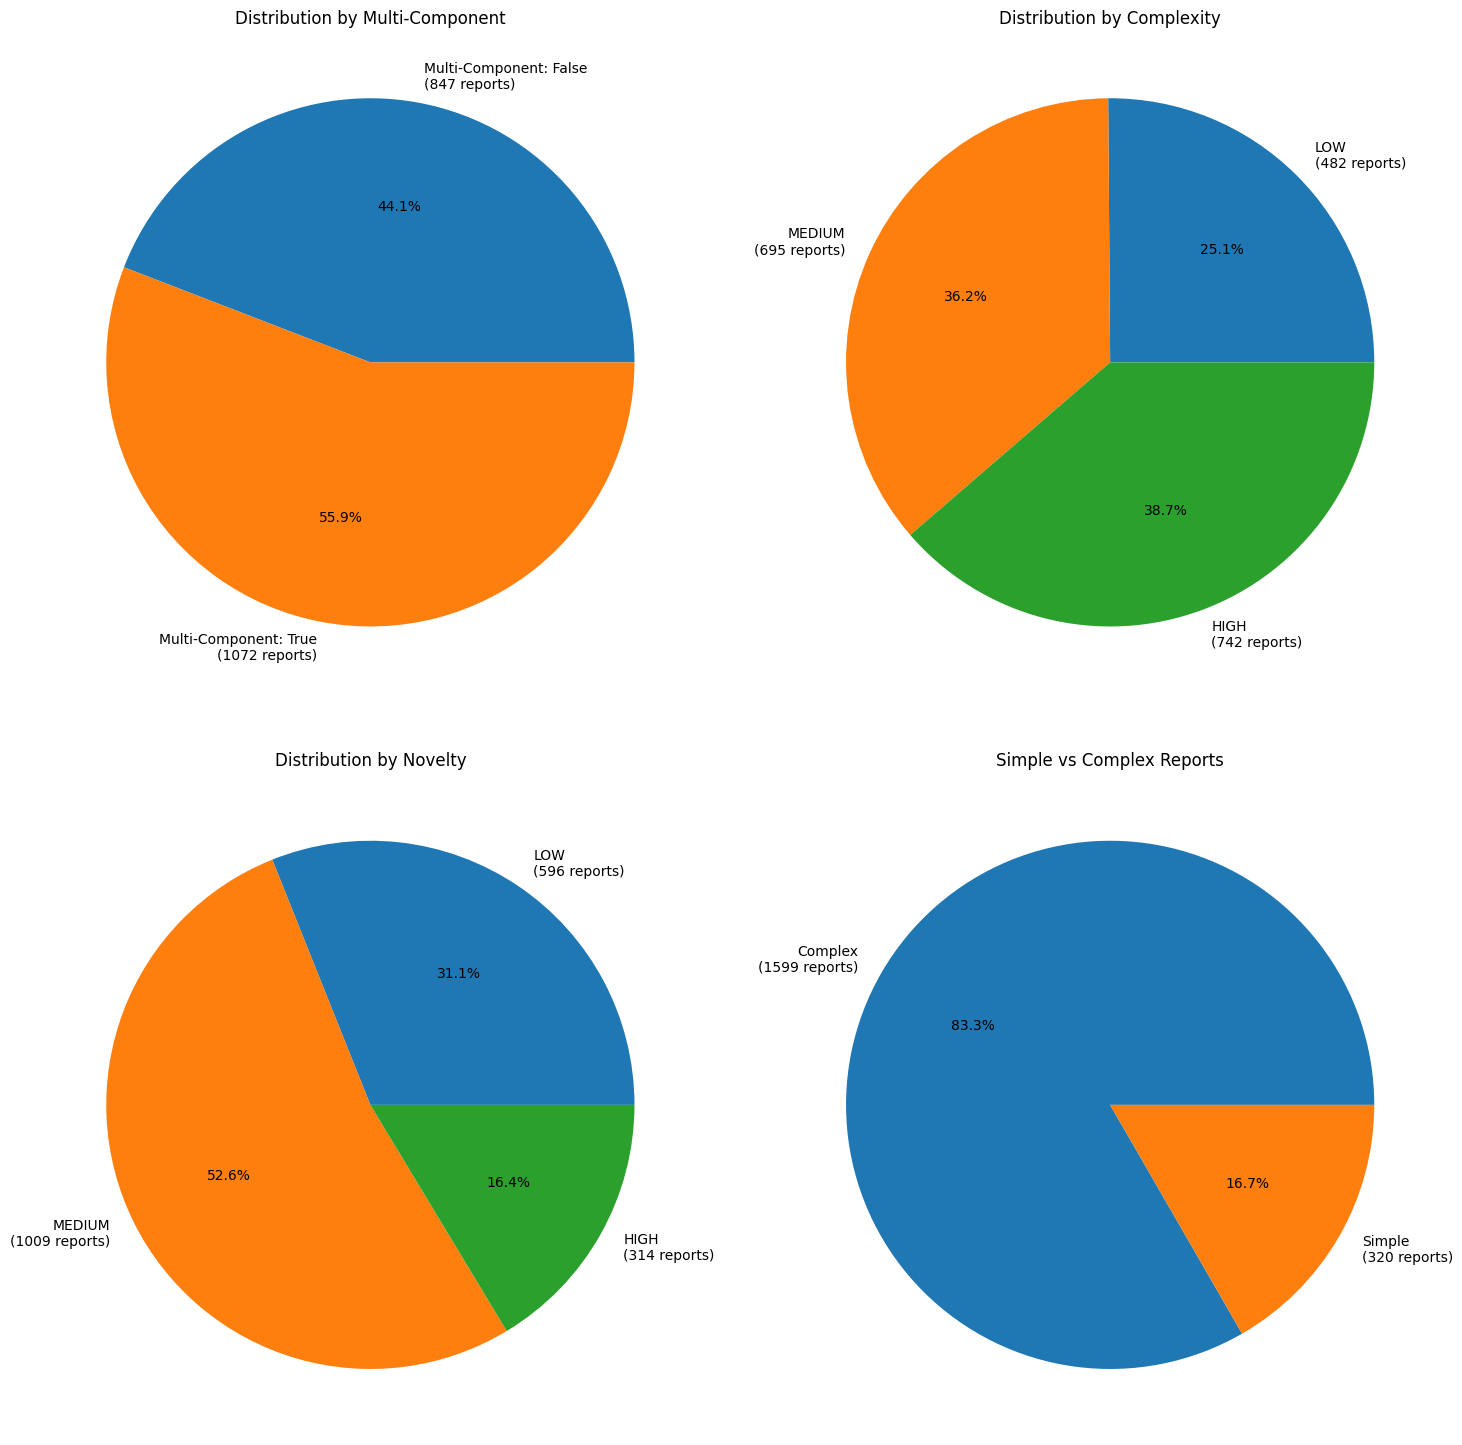

In [20]:
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt

START_YEAR = 2012
END_YEAR = 2026

def convert_weakness(weakness):
    ISSUES_MAPPING = {
        "AUTHZ/AUTN": [
            "Improper Access Control - Generic",
            "Insecure Direct Object Reference (IDOR)",
            "Improper Authentication - Generic", 
            "Authentication Bypass Using an Alternate Path or Channel",
            "Improper Authorization",
            "Authentication Bypass",
            "Missing Critical Step in Authentication",
            "Incorrect Authorization",
            "Improper Privilege Management",
            "Incorrect Privilege Assignment",
            "Privilege Escalation",
        ],
        "INJECTION": [
            "Cross-site Scripting (XSS) - Stored",
            "Cross-site Scripting (XSS) - Generic",
            "Cross-site Scripting (XSS) - Reflected",
            "Cross-site Scripting (XSS) - DOM",
            "SQL Injection",
            "Code Injection",
            "Command Injection - Generic",
            "OS Command Injection",
            "XML External Entities (XXE)",
            "XML Injection",
            "LDAP Injection",
            "Server-Side Request Forgery (SSRF)",
            "Resource Injection",
            "PHP Local File Inclusion",
            "Remote File Inclusion",
            "Blind SQL Injection",
            "CRLF Injection",
            "HTTP Response Splitting",
            "Use of Externally-Controlled Format String",
            "Reflected XSS"
        ]
    }
    # Check if weakness matches any values in the mapping
    for key, values in ISSUES_MAPPING.items():
        if weakness in values:
            return key
            
    # Return original weakness if no match found
    return weakness

def create_pie_chart(data, labels, title, ax):
    """Helper function to create a pie chart"""
    sizes = [count for count in data]
    ax.pie(sizes, labels=labels, autopct="%1.1f%%")
    ax.set_title(title)

def analyze_report_breakdowns():
    """Analyze reports across multiple dimensions"""
    reports_dir = Path("high_reports")
    authnz_dir = Path("authnz")
    
    # Initialize counters
    multi_component_counts = Counter()
    complexity_counts = Counter()
    novelty_counts = Counter() 
    simple_vs_complex_counts = Counter()
    
    # Process all reports
    for report_file in reports_dir.glob("*.json"):
        with open(report_file, "r") as f:
            try:
                report = json.load(f)
                
                # Count multi-component
                is_multi = report.get("is_multi_component", False)
                multi_component_counts[str(is_multi)] += 1
                
                # Count complexity
                complexity = report.get("complexity", "UNKNOWN")
                complexity_counts[complexity] += 1
                
                # Count novelty
                novelty = report.get("novelty", "UNKNOWN") 
                novelty_counts[novelty] += 1
                # Count simple vs complex
                is_simple = False
                weakness = report.get("weaknesses", [])
                if not weakness:
                    continue

                weakness = convert_weakness(weakness[0])
                if weakness == "INJECTION":
                    if not is_multi and complexity == "LOW" and novelty == "LOW":
                        is_simple = True

                elif weakness == "AUTHZ/AUTN":
                    # Check authnz analysis
                    authnz_file = authnz_dir / report_file.name
                    if authnz_file.exists():
                        with open(authnz_file, "r") as af:
                            authnz_data = json.load(af)
                            if (authnz_data.get("idor_detectable", False) or 
                                authnz_data.get("authnz_bypass_detectable", False)):
                                is_simple = True
                
                simple_vs_complex_counts["Simple" if is_simple else "Complex"] += 1
                
            except (json.JSONDecodeError, KeyError):
                continue
    # Create subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 15))
    
    # Multi-component breakdown
    multi_labels = [f"Multi-Component: {k}\n({v} reports)" 
                   for k,v in multi_component_counts.items()]
    create_pie_chart(multi_component_counts.values(), 
                    multi_labels,
                    "Distribution by Multi-Component",
                    ax1)
    
    # Complexity breakdown  
    complexity_labels = [f"{k}\n({v} reports)"
                        for k,v in complexity_counts.items()]
    create_pie_chart(complexity_counts.values(),
                    complexity_labels, 
                    "Distribution by Complexity",
                    ax2)
    
    # Novelty breakdown
    novelty_labels = [f"{k}\n({v} reports)"
                     for k,v in novelty_counts.items()]
    create_pie_chart(novelty_counts.values(),
                    novelty_labels,
                    "Distribution by Novelty",
                    ax3)
    
    # Simple vs Complex
    simple_labels = [f"{k}\n({v} reports)"
                    for k,v in simple_vs_complex_counts.items()]
    create_pie_chart(simple_vs_complex_counts.values(),
                    simple_labels,
                    "Simple vs Complex Reports",
                    ax4)
    
    plt.tight_layout()
    plt.show()

# Run the analysis
analyze_report_breakdowns()


In [ ]:
def convert_weakness(weakness):
    ISSUES_MAPPING = {
        "AUTHZ/AUTN": [
            "Improper Access Control - Generic",
            "Insecure Direct Object Reference (IDOR)",
            "Improper Authentication - Generic", 
            "Authentication Bypass Using an Alternate Path or Channel",
            "Improper Authorization",
            "Authentication Bypass",
            "Missing Critical Step in Authentication",
            "Incorrect Authorization",
            "Improper Privilege Management",
            "Incorrect Privilege Assignment",
            "Privilege Escalation",
        ],
        "INJECTION": [
            "Cross-site Scripting (XSS) - Stored",
            "Cross-site Scripting (XSS) - Generic",
            "Cross-site Scripting (XSS) - Reflected",
            "Cross-site Scripting (XSS) - DOM",
            "SQL Injection",
            "Code Injection",
            "Command Injection - Generic",
            "OS Command Injection",
            "XML External Entities (XXE)",
            "XML Injection",
            "LDAP Injection",
            "Server-Side Request Forgery (SSRF)",
            "Resource Injection",
            "PHP Local File Inclusion",
            "Remote File Inclusion",
            "Blind SQL Injection",
            "CRLF Injection",
            "HTTP Response Splitting",
            "Use of Externally-Controlled Format String",
            "Reflected XSS"
        ]
    }    
    
    # Check if weakness matches any values in the mapping
    for key, values in ISSUES_MAPPING.items():
        if weakness in values:
            return key
            
    # Return original weakness if no match found
    return weakness


In [ ]:
def analyze_top_weaknesses_by_year():
    """Analyze top 5 weaknesses for each year from 2019-2025 (HIGH severity only)"""
    reports_dir = Path("reports")
    
    # Initialize yearly weakness counters
    yearly_weaknesses = {year: Counter() for year in range(START_YEAR, END_YEAR)}
    
    # Process all reports
    for report_file in reports_dir.glob("*.json"):
        with open(report_file, "r") as f:
            try:
                report = json.load(f)
                
                # Skip if not HIGH severity
                severity = map_severity_to_level(report.get("severity"))
                if severity != SeverityLevel.HIGH.value:
                    continue
                    
                # Get year and weaknesses
                year = epoch_to_year(report["disclosed_date"])
                if year < START_YEAR or year > END_YEAR:
                    continue
                    
                weaknesses = report.get("weaknesses", [])
                if not weaknesses:
                    continue
                    
                # Count each weakness for that year
                for weakness in weaknesses:
                    weakness = convert_weakness(weakness)
                    yearly_weaknesses[year][weakness] += 1
                    
            except (json.JSONDecodeError, KeyError):
                continue
                
    # Plot results
    fig, ax = plt.subplots(figsize=(15, 8))
    
    x = np.arange(START_YEAR, END_YEAR)
    width = 0.15
    offsets = np.linspace(-2*width, 2*width, 5)
    
    for i in range(END_YEAR - START_YEAR):
        yearly_values = []
        weakness_names = []
        
        for year in range(START_YEAR, END_YEAR):
            # Get top 5 weaknesses for this year
            top_5 = yearly_weaknesses[year].most_common(5)
            
            # Print top 5 vulnerabilities for this year
            print(f"\nTop 5 vulnerabilities for {year}:")
            for rank, (weakness, count) in enumerate(top_5, 1):
                print(f"{rank}. {weakness}: {count}")
            
            # Get ith weakness if available, otherwise 0
            if i < len(top_5):
                weakness_names.append(top_5[i][0])
                yearly_values.append(top_5[i][1])
            else:
                yearly_values.append(0)
                
        # Plot bar for this weakness position
        if any(yearly_values):  # Only plot if there are non-zero values
            # Use most common weakness name across years
            most_common_name = max(set(weakness_names), key=weakness_names.count)
            ax.bar(x + offsets[i], yearly_values, width, 
                   label=f"#{i+1}: {most_common_name}")
            
    ax.set_xlabel("Year")
    ax.set_ylabel("Number of Reports")
    ax.set_title("Top 5 HIGH Severity Weaknesses by Year (2019-2025)")
    ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    ax.set_xticks(x)
    
    plt.tight_layout() 
    plt.show()

# Run the analysis
analyze_top_weaknesses_by_year()



Year 2019:
#1: AUTHZ/AUTN (41 reports)
#2: XSS (26 reports)
#3: SQL Injection (18 reports)
#4: Information Disclosure (16 reports)
#5: Code Injection (13 reports)

Year 2020:
#1: AUTHZ/AUTN (79 reports)
#2: XSS (33 reports)
#3: None (26 reports)
#4: Path Traversal (23 reports)
#5: Code Injection (21 reports)

Year 2021:
#1: AUTHZ/AUTN (63 reports)
#2: XSS (27 reports)
#3: Information Disclosure (26 reports)
#4: None (26 reports)
#5: Code Injection (19 reports)

Year 2022:
#1: AUTHZ/AUTN (42 reports)
#2: XSS (28 reports)
#3: None (19 reports)
#4: Information Disclosure (16 reports)
#5: Path Traversal (16 reports)

Year 2023:
#1: AUTHZ/AUTN (38 reports)
#2: XSS (18 reports)
#3: Code Injection (12 reports)
#4: Information Disclosure (11 reports)
#5: SQL Injection (6 reports)

Year 2024:
#1: AUTHZ/AUTN (38 reports)
#2: XSS (12 reports)
#3: None (11 reports)
#4: Information Disclosure (10 reports)
#5: Path Traversal (6 reports)

Year 2025:
#1: AUTHZ/AUTN (9 reports)
#2: None (4 reports)
#3

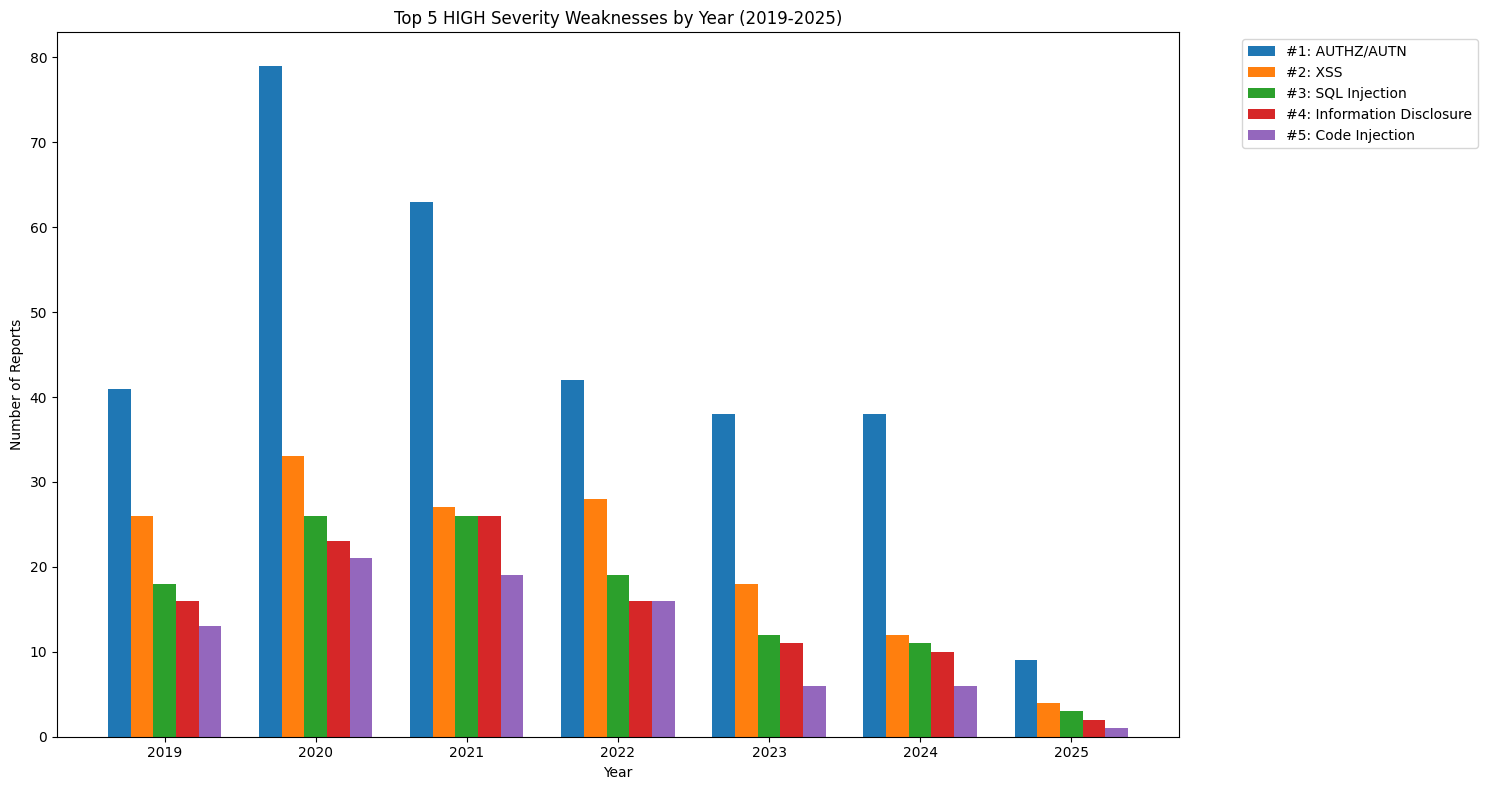

In [8]:
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt

def epoch_to_year(epoch_time):
    """Convert Unix epoch timestamp to year
    
    Args:
        epoch_time (int): Unix epoch timestamp
        
    Returns:
        int: Year extracted from timestamp
    """
    return datetime.fromtimestamp(epoch_time).year


def convert_weakness(weakness):
    ISSUES_MAPPING = {
        "XSS": [
            "Cross-site Scripting (XSS) - Stored",
            "Cross-site Scripting (XSS) - DOM", 
            "Cross-site Scripting (XSS) - Reflected",
            "Cross-site Scripting (XSS) - Generic",
            "Reflected XSS"
        ],
        "AUTHZ/AUTN": [
            "Improper Access Control - Generic",
            "Insecure Direct Object Reference (IDOR)",
            "Improper Authentication - Generic", 
            "Authentication Bypass Using an Alternate Path or Channel",
            "Improper Authorization",
            "Authentication Bypass",
            "Missing Critical Step in Authentication",
            "Incorrect Authorization",
            "Improper Privilege Management",
            "Incorrect Privilege Assignment",
            "Privilege Escalation",
        ]
    }
    # Check if weakness matches any values in the mapping
    for key, values in ISSUES_MAPPING.items():
        if weakness in values:
            return key
            
    # Return original weakness if no match found
    return weakness

def analyze_top_weaknesses_by_year():
    """Analyze top 5 weaknesses for each year from 2019-2025 (HIGH severity only)"""
    reports_dir = Path("reports")
    
    # Initialize yearly weakness counters
    yearly_weaknesses = {year: Counter() for year in range(2019, 2026)}
    
    # Process all reports
    for report_file in reports_dir.glob("*.json"):
        with open(report_file, "r") as f:
            try:
                report = json.load(f)
                
                # Skip if not HIGH severity
                severity = map_severity_to_level(report.get("severity"))
                if severity != SeverityLevel.HIGH.value:
                    continue
                    
                # Get year and weaknesses
                year = epoch_to_year(report["disclosed_date"])
                if year < 2019 or year > 2025:
                    continue
                    
                weaknesses = report.get("weaknesses", [])
                if not weaknesses:
                    continue
                    
                # Count each weakness for that year
                for weakness in weaknesses:
                    weakness = convert_weakness(weakness)
                    yearly_weaknesses[year][weakness] += 1
                    
            except (json.JSONDecodeError, KeyError):
                continue
                
    # Plot results
    fig, ax = plt.subplots(figsize=(15, 8))
    
    x = np.arange(2019, 2026)
    width = 0.15
    offsets = np.linspace(-2*width, 2*width, 5)
    
    for i in range(5):
        yearly_values = []
        weakness_names = []
        
        for year in range(2019, 2026):
            # Get top 5 weaknesses for this year
            top_5 = yearly_weaknesses[year].most_common(5)
            
            # Get ith weakness if available, otherwise 0
            if i < len(top_5):
                weakness_names.append(top_5[i][0])
                yearly_values.append(top_5[i][1])
                if i == 0:  # Only print once per year
                    print(f"\nYear {year}:")
                    for rank, (weakness, count) in enumerate(top_5, 1):
                        print(f"#{rank}: {weakness} ({count} reports)")
            else:
                yearly_values.append(0)
                
        # Plot bar for this weakness position
        if any(yearly_values):  # Only plot if there are non-zero values
            ax.bar(x + offsets[i], yearly_values, width, 
                   label=f"#{i+1}: {weakness_names[0]}")
            
    ax.set_xlabel("Year")
    ax.set_ylabel("Number of Reports")
    ax.set_title("Top 5 HIGH Severity Weaknesses by Year (2019-2025)")
    ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    ax.set_xticks(x)
    
    plt.tight_layout() 
    plt.show()

# Run the analysis
analyze_top_weaknesses_by_year()


In [4]:
# Count reports with both IDOR and AuthNZ bypass detectable
reports_dir = Path("authnz")
total_reports = 0
both_detectable = 0

for report_file in reports_dir.glob("*.json"):
    with open(report_file, "r") as f:
        try:
            report = json.load(f)
            total_reports += 1
            if report["idor_detectable"] and report["authnz_byppass_detectable"]:
                both_detectable += 1
        except json.JSONDecodeError:
            continue

print(f"Reports with both IDOR and AuthNZ bypass detectable: {both_detectable}")
print(f"Total reports: {total_reports}")
print(f"Percentage: {(both_detectable/total_reports)*100:.1f}%")


Reports with both IDOR and AuthNZ bypass detectable: 148
Total reports: 352
Percentage: 42.0%
